# Linear Regression, KNN Regressor, XGBoost

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_excel('../data/freshwater_datamaster.xlsx', sheet_name='main')
df = df[['SHIP-ROUTE','DISTANCE', 'FRESH_WATER']]

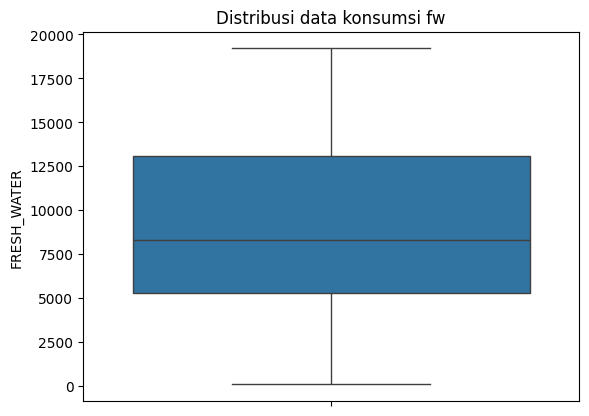

In [3]:
import seaborn as sns
sns.boxplot(data=df, y='FRESH_WATER')
plt.title("Distribusi data konsumsi fw")
plt.show()


In [4]:
print(df.columns.tolist())

['SHIP-ROUTE', 'DISTANCE', 'FRESH_WATER']


In [5]:
df = df.rename(columns={'SHIP-ROUTE': 'SHIP_ROUTE'})
print(df.columns.tolist())

['SHIP_ROUTE', 'DISTANCE', 'FRESH_WATER']


In [6]:
df_encoded = pd.get_dummies(df, columns=['SHIP_ROUTE'])

In [7]:
X = df_encoded.drop(columns=['FRESH_WATER'])
y = df_encoded['FRESH_WATER']


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### XGBoost

In [9]:

# Apply Standard Scaling
from sklearn.preprocessing import StandardScaler
import joblib

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Save the scaler
joblib.dump(scaler, '../models/scalerdummy.pkl')

# Convert to DMatrix using scaled data
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)


import xgboost as xgb
from sklearn.metrics import mean_squared_error


dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)


params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.25,
    'max_depth': 8,
    'seed': 200,
    'eval_metric': 'rmse'
}


xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=15000,
    evals=[(dvalid, "validation")],
    early_stopping_rounds=50,
    verbose_eval=True
)


y_pred = xgb_model.predict(dvalid)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")


[0]	validation-rmse:3616.94911
[1]	validation-rmse:2826.19272
[2]	validation-rmse:2231.24026
[3]	validation-rmse:1803.87557
[4]	validation-rmse:1498.24915
[5]	validation-rmse:1283.82676
[6]	validation-rmse:1134.71071
[7]	validation-rmse:1034.07603
[8]	validation-rmse:971.30364
[9]	validation-rmse:932.47071
[10]	validation-rmse:909.62895
[11]	validation-rmse:890.83741
[12]	validation-rmse:869.12210
[13]	validation-rmse:861.43860
[14]	validation-rmse:855.35960
[15]	validation-rmse:849.40886
[16]	validation-rmse:844.00351
[17]	validation-rmse:845.13701
[18]	validation-rmse:842.57735
[19]	validation-rmse:840.86641
[20]	validation-rmse:837.89746
[21]	validation-rmse:837.78656
[22]	validation-rmse:836.24031
[23]	validation-rmse:834.57340
[24]	validation-rmse:833.50730
[25]	validation-rmse:830.80954
[26]	validation-rmse:831.76395
[27]	validation-rmse:831.80398
[28]	validation-rmse:831.88494
[29]	validation-rmse:831.85928
[30]	validation-rmse:831.90804
[31]	validation-rmse:829.08628
[32]	valid

### Test

In [10]:
import numpy as np

In [19]:
test_df = pd.DataFrame({'DISTANCE': [537]})

route_columns = [col for col in X_train.columns if col.startswith('SHIP_ROUTE_')]
for col in route_columns:
    test_df[col] = 0

test_df = test_df[X_train.columns]
dmatrix_test = xgb.DMatrix(test_df)

prediction = xgb_model.predict(dmatrix_test)
print(f"Predicted Fresh Water Consumption: {prediction[0]:.2f} liters")

Predicted Fresh Water Consumption: 7746.99 liters


C:\Users\ilham\AppData\Local\Temp\ipykernel_50284\1348943667.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[col] = 0
C:\Users\ilham\AppData\Local\Temp\ipykernel_50284\1348943667.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[col] = 0
C:\Users\ilham\AppData\Local\Temp\ipykernel_50284\1348943667.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1)

In [12]:
import pandas as pd
import xgboost as xgb


df_encoded = pd.get_dummies(df, columns=['SHIP_ROUTE'], prefix='SHIP_ROUTE')


for col in X_train.columns:
    if col not in df_encoded.columns:
        df_encoded[col] = 0


df_encoded = df_encoded[X_train.columns]


dmatrix_test = xgb.DMatrix(df_encoded)


predictions = xgb_model.predict(dmatrix_test)


actual = df['FRESH_WATER'].values
errors = actual - predictions
squared_errors = errors ** 2


results_df = pd.DataFrame({
    'DISTANCE': df['DISTANCE'],
    'Actual (At)': actual,
    'Predicted (Ft)': predictions,
    'Error (At - Ft)': errors,
    'Squared Error': squared_errors
})

mse = sum(squared_errors) / len(df)
print(results_df.head(100))
print(f"\nTotal Samples: {len(df)}")
print(f"Manual MSE: {mse:.6f}")


    DISTANCE  Actual (At)  Predicted (Ft)  Error (At - Ft)  Squared Error
0         17          100      255.432343      -155.432343   24159.213104
1         17          100      255.432343      -155.432343   24159.213104
2         50          200      295.237274       -95.237274    9070.138391
3         50          200      470.513123      -270.513123   73177.349476
4         50          200      470.513123      -270.513123   73177.349476
..       ...          ...             ...              ...            ...
95       152         3050     3740.282959      -690.282959  476490.563464
96       235         3100     4014.210205      -914.210205  835780.299069
97       252         3200     3268.047607       -68.047607    4630.476876
98       235         3200     4014.210205      -814.210205  662938.258053
99       152         3200     3740.282959      -540.282959  291905.675769

[100 rows x 5 columns]

Total Samples: 1185
Manual MSE: 526156.029432


In [13]:
import joblib
import json

# Save model
joblib.dump(xgb_model, 'xgb_modeljson.pkl')

# Save the list of feature columns (needed for prediction input)
with open('xgb_columns.json', 'w') as f:
    json.dump(X_train.columns.tolist(), f)
